In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from numpy.linalg import inv

sns.set_style('whitegrid')

def cov2corr(S):
    return S[0, 1] / np.sqrt(S[0, 0] * S[1, 1])

blue = pd.read_csv("bluecrab.dat", names=["body","rear"], delimiter=" ")
orange = pd.read_csv("orangecrab.dat", names=["body","rear"], delimiter=" ")

# Blue posterior
N = blue.shape[0]
mu0 = blue.mean().values
A0 = S0 = blue.cov().values
v0 = 4

S = blue.cov()
A_n = inv(inv(A0) + N * inv(S))
mu_n = A_n @ (inv(A0) @ mu0 + N*inv(S) @ blue.mean())

v_n = v0 + N
S_n = S0 + S

blue_theta_pos_rv = stats.multivariate_normal(mu_n, A_n)
blue_sigma_pos_rv = stats.invwishart(df=v_n, scale=S_n)

# Orange posterior
N = orange.shape[0]
mu0 = orange.mean().values
A0 = S0 = orange.cov().values
v0 = 4

S = orange.cov()
A_n = inv(inv(A0) + N * inv(S))
mu_n = A_n @ (inv(A0) @ mu0 + N*inv(S) @ orange.mean())

v_n = v0 + N
S_n = S0 + S

orange_theta_pos_rv = stats.multivariate_normal(mu_n, A_n)
orange_sigma_pos_rv = stats.invwishart(df=v_n, scale=S_n)

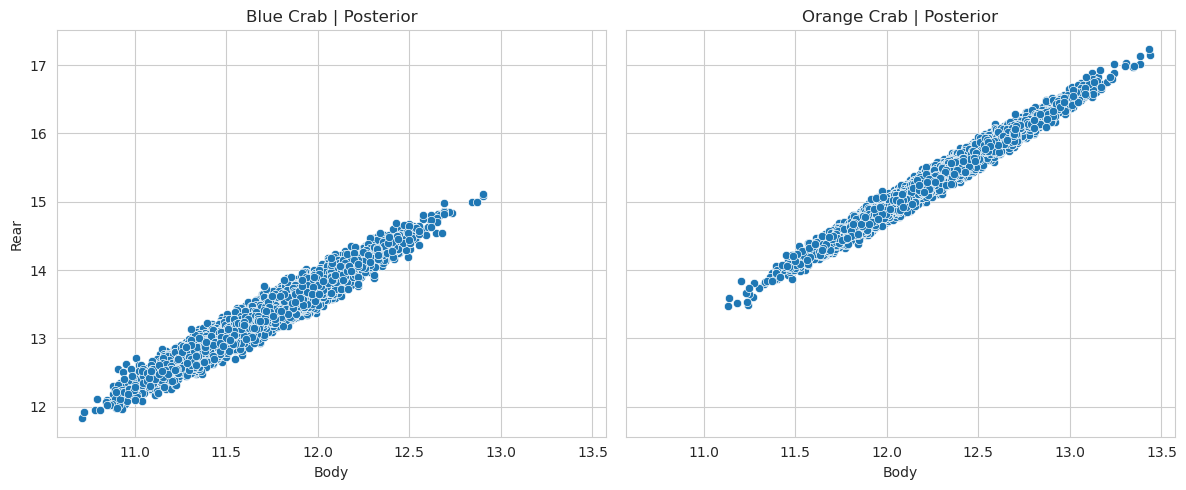

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

X = blue_theta_pos_rv.rvs(10000)
sns.scatterplot(x=X[:,0], y=X[:,1], ax=ax[0])
ax[0].set_title('Blue Crab | Posterior')
ax[0].set_xlabel("Body")
ax[0].set_ylabel("Rear")

X = orange_theta_pos_rv.rvs(10000)
sns.scatterplot(x=X[:,0], y=X[:,1], ax=ax[1])
ax[1].set_title('Orange Crab | Posterior')
ax[1].set_xlabel("Body")
ax[1].set_ylabel("Rear")

# figure setups
fig.tight_layout()
fig.show()

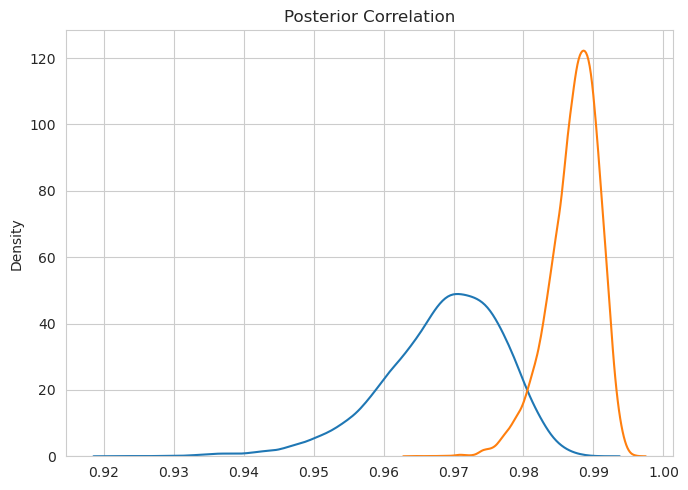

In [12]:
fig, ax = plt.subplots(figsize=(7, 5))

sns.kdeplot([cov2corr(x) for x in blue_sigma_pos_rv.rvs(10000)], label='Blue', ax=ax)
sns.kdeplot([cov2corr(x) for x in orange_sigma_pos_rv.rvs(10000)], label='Orange', ax=ax)
ax.set_title("Posterior Correlation")

fig.tight_layout()
fig.show()